In [1]:
import datetime as dtm
import requests
import pandas as pd
import time
import os
import numpy as np
import scipy as sp
import pickle
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import src.data_retriever as intrinio
import src.pso as pso
import src.trading_bot as bot
import random
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
%matplotlib inline

In [2]:
random.seed(42)
datefrom = dtm.datetime(2010, 1, 1)
dateto = dtm.datetime(2019, 5, 1)

In [3]:
#DOW 30
# stock_names = ['AAPL', 'CSCO', 'WMT', 'MCD', 'GS', 'AXP', 'BA', 'KO', 'V', 'WMT', 'UNH']
stock_names = ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'XOM', 'GS',
               'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG',
               'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'DIS']
# stock_names = ['AAPL']

In [4]:
stocks_filename = 'stocks_dow30_full.csv'
if os.path.isfile(stocks_filename):
    stocks = pd.read_csv(stocks_filename)
    stocks['date'] = pd.to_datetime(stocks['date'], format="%Y-%m-%d")
else:
    stocks = intrinio.get_stocks_data(stock_names, datefrom, dateto)
    stocks.to_csv(stocks_filename, index_label='id', columns=list(stocks.columns))

### Подготовка к тестированию

In [5]:
train_datefrom = datefrom
train_dateto = dtm.datetime(2014, 1, 1)

valid_datefrom = train_dateto
valid_dateto = dtm.datetime(2015, 1, 1)

test_datefrom = dtm.datetime(2015, 1, 1)
test_dateto = dtm.datetime(2016, 1, 1)

In [6]:
data = stocks.drop(0).reset_index(drop=True)
data['date'] = data['date'].map(lambda x: x.timestamp())
#data.drop('date', axis=1)
#test_data = data[data['stock_name'] == 'PFE']
#data = data[data['stock_name'] != 'KO']
#data = data.drop('stock_name', axis=1)
#test_data = test_data.drop('stock_name', axis=1)
#test_data = test_data[test_data['date'] > test_datefrom.timestamp()]

In [7]:
#to_normalize = ['volume_prev1', 'ebitda']
#data['date_norm'] = MinMaxScaler().fit_transform(data['date'].as_matrix().reshape(-1, 1))
#data['volume_prev1'] = MinMaxScaler().fit_transform(data['volume_prev1'].as_matrix().reshape(-1, 1))
#data['ebitda'] = MinMaxScaler().fit_transform(data['ebitda'].as_matrix().reshape(-1, 1))

lbl_encoder=LabelEncoder()
data['stock_name'] = lbl_encoder.fit_transform(data['stock_name'].as_matrix().reshape(-1, 1))
#test_data['stock_name'] = lbl_encoder.transform(test_data['stock_name'].as_matrix().reshape(-1, 1))
# test_data = data[data['stock_name'] == 0]
# data = data[data['stock_name'] != 0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
#lbl_encoder.classes_

In [9]:
#lbl_encoder.inverse_transform(np.array([1]))

In [10]:
train_data = data[data['date'] <= train_dateto.timestamp()]
train_data = train_data[~train_data['stock_name'].isin((lbl_encoder.transform(np.array(['VZ']))[0], lbl_encoder.transform(np.array(['AAPL']))[0]))]
X_train = train_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_train))
Y_train_regr = train_data['close']
Y_train_classify = train_data['close'] > train_data['open']

26157


In [11]:
valid_data = data[data['date'] > valid_datefrom.timestamp()]
valid_data = valid_data[valid_data['date'] < valid_dateto.timestamp()]
# valid_data = valid_data.query('(stock_name == 0)')
X_valid = valid_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_valid))
Y_valid_regr = valid_data['close']
Y_valid_classify = valid_data['close'] > valid_data['open']

7056


In [12]:
test_data = data[data['date'] > test_datefrom.timestamp()]
test_data = test_data[test_data['date'] < test_dateto.timestamp()]
# coca_label = lbl_encoder.transform(np.array(['KO']))[0]
# intel_label = lbl_encoder.transform(np.array(['INTC']))[0]
# pfizer_label = lbl_encoder.transform(np.array(['PFE']))[0]
# test_data = test_data[test_data['stock_name'].isin((coca_label, pfizer_label, intel_label))]
# test_data = test_data[test_data['stock_name'] == lbl_encoder.transform(np.array(['UNH']))[0]]
# test_data = test_data[test_data['stock_name'] == lbl_encoder.transform(np.array(['CVX']))[0]]
test_data = test_data[test_data['stock_name'] == lbl_encoder.transform(np.array(['AAPL']))[0]]
len(test_data)

252

In [13]:
ts = time.time()
class_params = {
'max_depth': 14,
  'n_estimators': 631,
  'min_child_weight': 308,
  'colsample_bytree': 0.3835295385104849,
  'subsample': 0.8779845029326574,
  'eta': 0.8885150603875441,}
model_class = XGBClassifier(**class_params)

model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='error',
        early_stopping_rounds = 10)
    
time.time() - ts

[0]	validation_0-error:0.39477	validation_1-error:0.40292
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.381275	validation_1-error:0.396259
[2]	validation_0-error:0.381695	validation_1-error:0.393849
[3]	validation_0-error:0.367779	validation_1-error:0.380952
[4]	validation_0-error:0.360592	validation_1-error:0.374433
[5]	validation_0-error:0.355775	validation_1-error:0.371882
[6]	validation_0-error:0.353901	validation_1-error:0.366497
[7]	validation_0-error:0.351722	validation_1-error:0.363095
[8]	validation_0-error:0.350461	validation_1-error:0.361111
[9]	validation_0-error:0.343961	validation_1-error:0.3553
[10]	validation_0-error:0.341706	validation_1-error:0.352041
[11]	validation_0-error:0.339947	validation_1-error:0.35034
[12]	validation_0-error:0.338609	validation_1-error:0.34538
[13]	validation_0-error:0.336124	validation_1-error:0.341553
[

10.32242226600647

In [14]:
test_datefrom

datetime.datetime(2015, 1, 1, 0, 0)

In [15]:
test_dateto

datetime.datetime(2016, 1, 1, 0, 0)

In [16]:
test_data['open'].head(1)

58572    111.39
Name: open, dtype: float64

In [17]:
def strategy(row):
    strategy_input = pd.DataFrame([row])
    strategy_input = strategy_input.drop(['date','close','adj_close', 'volume'], axis=1)
    decision = 'buy' if model_class.predict(strategy_input) else 'sell'
    return decision

cash_result, min_cash, max_cash, cashes, diffs = bot.simulate_trading_stat(strategy, test_data, initial_cash=213.5*20, multipl=10, interest_percent=0)
print((cash_result, min_cash, max_cash))

sell: open: 111.39, cash=4289.6,  diff=-20.600000000000023, interest=0.0
sell: open: 108.29, cash=4309.0,  diff=-20.400000000000063, interest=0.0
sell: open: 106.54, cash=4310.8,  diff=-2.8000000000000114, interest=0.0
sell: open: 107.2, cash=4304.3,  diff=5.499999999999972, interest=0.0
buy: open: 109.23, cash=4329.900000000001, diff=26.599999999999966, interest=0.0
sell: open: 112.67, cash=4335.500000000001,  diff=-6.599999999999966, interest=0.0
sell: open: 112.6, cash=4368.000000000001,  diff=-33.49999999999994, interest=0.0
sell: open: 111.43, cash=4379.100000000001,  diff=-12.10000000000008, interest=0.0
buy: open: 109.04, cash=4385.700000000001, diff=7.599999999999909, interest=0.0
sell: open: 110.0, cash=4416.500000000001,  diff=-31.800000000000068, interest=0.0
buy: open: 107.03, cash=4405.100000000001, diff=-10.400000000000063, interest=0.0
buy: open: 107.84, cash=4412.9000000000015, diff=8.799999999999955, interest=0.0
buy: open: 108.95, cash=4417.9000000000015, diff=5.99999

sell: open: 127.48, cash=5058.399999999996,  diff=-4.500000000000028, interest=0.0
buy: open: 127.21, cash=5066.399999999996, diff=9.000000000000199, interest=0.0
sell: open: 128.86, cash=5078.999999999996,  diff=-13.600000000000136, interest=0.0
sell: open: 127.67, cash=5087.199999999996,  diff=-9.200000000000017, interest=0.0
sell: open: 125.46, cash=5095.499999999996,  diff=-9.299999999999926, interest=0.0
sell: open: 125.57, cash=5095.949999999996,  diff=-1.4499999999999602, interest=0.0
sell: open: 126.9, cash=5097.949999999996,  diff=-3.0000000000001137, interest=0.0
sell: open: 126.43, cash=5096.849999999997,  diff=0.09999999999990905, interest=0.0
sell: open: 124.94, cash=5085.249999999996,  diff=10.600000000000023, interest=0.0
sell: open: 125.89, cash=5086.249999999996,  diff=-2.0000000000000284, interest=0.0
sell: open: 124.48, cash=5104.349999999997,  diff=-19.100000000000108, interest=0.0
sell: open: 123.85, cash=5141.149999999997,  diff=-37.80000000000001, interest=0.0
se

sell: open: 119.2, cash=5178.649999999999,  diff=0.9999999999999432, interest=0.0
sell: open: 119.27, cash=5192.8499999999985,  diff=-15.19999999999996, interest=0.0
sell: open: 117.33, cash=5176.3499999999985,  diff=15.499999999999972, interest=0.0
sell: open: 119.21, cash=5187.149999999999,  diff=-11.799999999999926, interest=0.0
sell: open: 118.29, cash=5190.949999999999,  diff=-4.80000000000004, interest=0.0
buy: open: 117.99, cash=5193.049999999999, diff=3.1000000000000227, interest=0.0
sell: open: 118.75, cash=5206.15,  diff=-14.099999999999966, interest=0.0
sell: open: 117.05, cash=5212.849999999999,  diff=-7.69999999999996, interest=0.0
sell: open: 116.55, cash=5225.349999999999,  diff=-13.499999999999943, interest=0.0
buy: open: 115.29, cash=5261.749999999999, diff=37.39999999999995, interest=0.0
buy: open: 118.98, cash=5253.749999999999, diff=-7.000000000000028, interest=0.0
sell: open: 117.52, cash=5245.649999999999,  diff=7.10000000000008, interest=0.0
sell: open: 117.64, c

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


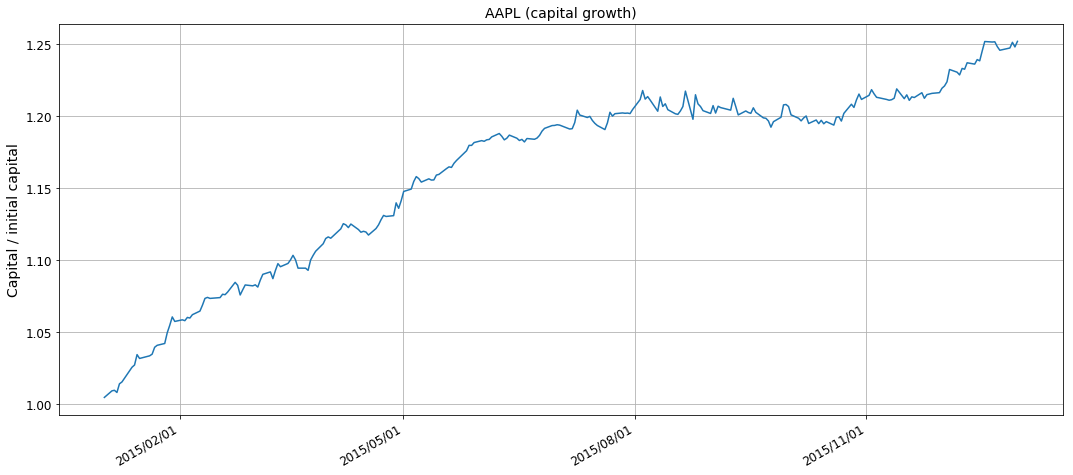

In [18]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(1, 1, figsize=(18,8))
x=[dtm.datetime.fromtimestamp(tmstmp) for tmstmp in list(test_data['date'])]
y = list(map(lambda x: x/213.5/20, cashes))
plt.plot(x,y)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.ylabel('Capital / initial capital', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.title('AAPL (capital growth)', fontsize=14)
plt.grid()

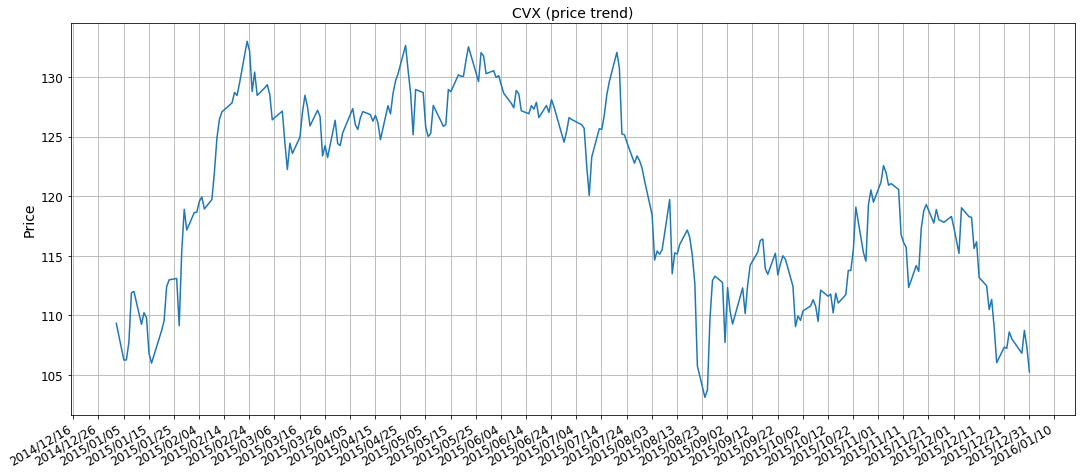

In [19]:
import matplotlib.dates as mdates

x=[dtm.datetime.fromtimestamp(tmstmp) for tmstmp in list(test_data['date'])]
y=[close_price for close_price in list(test_data['close'])]

fig, ax = plt.subplots(1, 1, figsize=(18,8))
plt.plot(x,y)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.ylabel('Price', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.title('CVX (price trend)', fontsize=14)
plt.grid()

x=[]
y=[]
k=1
t=time.time()
for multipl in np.arange(1, 1001, 10):
    cash_res = bot.simulate_trading(strategy, test_data, initial_cash=1000, multipl=multipl, interest_percent=0)
    x+=[multipl]
    y+=[cash_res[0]/1000000.0]
    k+=1
    if k%10 == 0:
        t_diff = time.time()-t
        print(f'============={k}: {t_diff}')

In [20]:
int(5000 / float(test_data['open'].head(1)))

44

In [21]:
capital_growth = pd.DataFrame(columns=['stock_name', 'avg_price', 'initial_cash', 'result_cash', 'capital_growth', 'min_cash', 'min_cash_perc', 'max_cash', 'max_cash_perc'])
for stock_name in stock_names:
    test_data = data[data['date'] > test_datefrom.timestamp()]
    test_data = test_data[test_data['date'] < test_dateto.timestamp()]
    test_data = test_data[test_data['stock_name'] == lbl_encoder.transform(np.array([stock_name]))[0]]
#     initial_cash = 20 * float(test_data['open'].head(1))
    initial_cash = 10000
    multipl = int(5000 / float(test_data['open'].head(1)))
    cash_result, min_cash, max_cash, cashes, diffs = bot.simulate_trading_stat(strategy, test_data, initial_cash=initial_cash, multipl=multipl, interest_percent=0)
    current_growth = pd.DataFrame([[stock_name, float(test_data['open'].mean()), initial_cash, cash_result, (cash_result / initial_cash - 1) * 100,  min_cash, (1 - min_cash/initial_cash) * 100, max_cash, max_cash/initial_cash * 100]], columns=['stock_name', 'avg_price', 'initial_cash', 'result_cash', 'capital_growth', 'min_cash', 'min_cash_perc', 'max_cash', 'max_cash_perc'])
    capital_growth = pd.concat([capital_growth, current_growth])

sell: open: 164.71, cash=10018.5,  diff=-19.50000000000017, interest=0.0
sell: open: 163.0, cash=10096.699999999999,  diff=-79.19999999999959, interest=0.0
sell: open: 160.82, cash=10160.8,  diff=-65.09999999999962, interest=0.0
sell: open: 159.9, cash=10162.8,  diff=-2.9999999999998295, interest=0.0
buy: open: 160.65, cash=10251.199999999999, diff=89.3999999999997, interest=0.0
sell: open: 163.85, cash=10317.099999999999,  diff=-66.8999999999997, interest=0.0
sell: open: 162.39, cash=10365.599999999999,  diff=-49.49999999999932, interest=0.0
buy: open: 162.23, cash=10316.3, diff=-48.29999999999956, interest=0.0
buy: open: 159.04, cash=10339.3, diff=24.00000000000034, interest=0.0
buy: open: 160.89, cash=10301.4, diff=-36.89999999999969, interest=0.0
buy: open: 159.86, cash=10364.599999999999, diff=64.19999999999959, interest=0.0
buy: open: 162.72, cash=10340.199999999999, diff=-23.400000000000034, interest=0.0
buy: open: 161.66, cash=10365.599999999999, diff=26.399999999999864, intere

buy: open: 159.12, cash=11973.399999999994, diff=22.200000000000273, interest=0.0
sell: open: 159.85, cash=12026.699999999993,  diff=-54.30000000000007, interest=0.0
sell: open: 157.08, cash=12061.999999999995,  diff=-36.30000000000024, interest=0.0
buy: open: 155.49, cash=12090.999999999995, diff=30.0, interest=0.0
buy: open: 156.6, cash=12100.499999999995, diff=10.49999999999983, interest=0.0
buy: open: 157.59, cash=12160.399999999994, diff=60.900000000000034, interest=0.0
buy: open: 159.36, cash=12147.099999999993, diff=-12.30000000000075, interest=0.0
sell: open: 159.85, cash=12151.199999999993,  diff=-5.099999999999625, interest=0.0
buy: open: 160.41, cash=12133.099999999993, diff=-17.099999999999795, interest=0.0
sell: open: 159.68, cash=12196.299999999994,  diff=-64.20000000000044, interest=0.0
sell: open: 157.85, cash=12253.199999999993,  diff=-57.900000000000205, interest=0.0
buy: open: 156.16, cash=12280.099999999993, diff=27.900000000000205, interest=0.0
sell: open: 155.92, 

sell: open: 157.23, cash=13770.299999999994,  diff=10.80000000000041, interest=0.0
buy: open: 157.86, cash=13804.999999999995, diff=35.69999999999993, interest=0.0
sell: open: 157.78, cash=13848.399999999994,  diff=-44.39999999999969, interest=0.0
buy: open: 156.0, cash=13836.899999999994, diff=-10.49999999999983, interest=0.0
buy: open: 155.61, cash=13913.899999999994, diff=77.99999999999983, interest=0.0
sell: open: 158.36, cash=13952.799999999994,  diff=-39.900000000000375, interest=0.0
buy: open: 156.18, cash=13988.099999999993, diff=36.299999999999386, interest=0.0
buy: open: 157.63, cash=14009.599999999993, diff=22.5, interest=0.0
buy: open: 158.68, cash=14016.699999999993, diff=8.099999999999454, interest=0.0
buy: open: 158.9, cash=14008.199999999993, diff=-7.5, interest=0.0
buy: open: 157.37, cash=14018.599999999993, diff=11.399999999999864, interest=0.0
buy: open: 158.06, cash=14004.699999999993, diff=-12.900000000000205, interest=0.0
buy: open: 157.51, cash=14018.099999999995

buy: open: 80.37, cash=10777.909999999994, diff=52.46999999999973, interest=0.0
sell: open: 81.41, cash=10800.759999999995,  diff=-23.85000000000015, interest=0.0
buy: open: 80.54, cash=10811.419999999995, diff=11.65999999999994, interest=0.0
sell: open: 80.84, cash=10788.689999999995,  diff=21.72999999999982, interest=0.0
sell: open: 81.12, cash=10836.979999999996,  diff=-49.29000000000036, interest=0.0
sell: open: 80.45, cash=10853.999999999996,  diff=-18.02000000000018, interest=0.0
buy: open: 79.97, cash=10859.359999999997, diff=6.360000000000241, interest=0.0
sell: open: 80.04, cash=10875.319999999998,  diff=-16.96000000000039, interest=0.0
sell: open: 79.94, cash=10899.229999999998,  diff=-24.90999999999994, interest=0.0
sell: open: 79.26, cash=10859.539999999999,  diff=38.68999999999946, interest=0.0
sell: open: 80.32, cash=10843.699999999999,  diff=14.84000000000006, interest=0.0
sell: open: 80.05, cash=10879.269999999999,  diff=-36.56999999999988, interest=0.0
sell: open: 79.7

buy: open: 76.95, cash=12324.449999999995, diff=2.6499999999998494, interest=0.0
sell: open: 77.05, cash=12328.749999999995,  diff=-5.299999999999699, interest=0.0
sell: open: 77.29, cash=12369.089999999995,  diff=-41.34000000000006, interest=0.0
sell: open: 73.06, cash=12397.769999999995,  diff=-29.68000000000012, interest=0.0
buy: open: 72.82, cash=12490.579999999996, diff=93.81000000000054, interest=0.0
buy: open: 73.3, cash=12536.749999999996, diff=47.17000000000003, interest=0.0
sell: open: 73.79, cash=12524.089999999997,  diff=11.65999999999994, interest=0.0
sell: open: 74.35, cash=12517.789999999995,  diff=5.300000000000452, interest=0.0
buy: open: 74.15, cash=12520.499999999995, diff=3.7099999999996385, interest=0.0
buy: open: 74.08, cash=12476.039999999995, diff=-43.45999999999964, interest=0.0
buy: open: 73.43, cash=12502.069999999994, diff=27.029999999999518, interest=0.0
buy: open: 74.15, cash=12494.709999999994, diff=-6.360000000000241, interest=0.0
buy: open: 74.31, cash=

sell: open: 128.15, cash=13191.679999999997,  diff=-103.40000000000038, interest=0.0
sell: open: 126.56, cash=13258.879999999997,  diff=-68.19999999999987, interest=0.0
sell: open: 124.77, cash=13236.319999999996,  diff=21.5600000000004, interest=0.0
sell: open: 126.68, cash=13193.959999999995,  diff=41.3599999999999, interest=0.0
sell: open: 127.39, cash=13240.039999999995,  diff=-47.080000000000325, interest=0.0
sell: open: 125.6, cash=13227.379999999996,  diff=11.660000000000025, interest=0.0
sell: open: 126.15, cash=13232.539999999995,  diff=-6.160000000000025, interest=0.0
buy: open: 127.41, cash=13299.299999999996, diff=67.75999999999965, interest=0.0
sell: open: 129.07, cash=13311.499999999995,  diff=-13.19999999999925, interest=0.0
buy: open: 128.38, cash=13390.139999999994, diff=79.6400000000001, interest=0.0
sell: open: 130.69, cash=13416.419999999995,  diff=-27.2800000000002, interest=0.0
sell: open: 130.0, cash=13412.779999999995,  diff=2.6400000000001, interest=0.0
buy: op

sell: open: 108.01, cash=14417.679999999991,  diff=104.27999999999957, interest=0.0
sell: open: 109.88, cash=14377.07999999999,  diff=39.60000000000025, interest=0.0
sell: open: 110.63, cash=14346.15999999999,  diff=29.9200000000003, interest=0.0
sell: open: 111.74, cash=14387.39999999999,  diff=-42.239999999999725, interest=0.0
sell: open: 110.19, cash=14416.759999999991,  diff=-30.3599999999999, interest=0.0
sell: open: 110.0, cash=14322.47999999999,  diff=93.2800000000002, interest=0.0
sell: open: 112.73, cash=14371.199999999992,  diff=-49.720000000000425, interest=0.0
sell: open: 110.82, cash=14327.519999999991,  diff=42.680000000000575, interest=0.0
sell: open: 111.29, cash=14374.039999999992,  diff=-47.52000000000055, interest=0.0
sell: open: 110.93, cash=14332.119999999992,  diff=40.919999999999675, interest=0.0
sell: open: 111.78, cash=14363.679999999991,  diff=-32.559999999999775, interest=0.0
sell: open: 110.8, cash=14321.759999999991,  diff=40.9200000000003, interest=0.0
buy

sell: open: 150.88, cash=12422.65,  diff=-48.64000000000004, interest=0.0
buy: open: 151.06, cash=12482.83, diff=61.17999999999944, interest=0.0
buy: open: 153.51, cash=12474.990000000002, diff=-6.839999999999179, interest=0.0
sell: open: 152.36, cash=12518.450000000003,  diff=-44.460000000000605, interest=0.0
sell: open: 150.83, cash=12553.930000000002,  diff=-36.4800000000003, interest=0.0
sell: open: 149.54, cash=12596.250000000002,  diff=-43.31999999999948, interest=0.0
sell: open: 148.59, cash=12625.270000000002,  diff=-30.019999999999698, interest=0.0
sell: open: 147.9, cash=12639.090000000002,  diff=-14.820000000000562, interest=0.0
sell: open: 147.07, cash=12673.050000000001,  diff=-34.959999999999525, interest=0.0
sell: open: 145.25, cash=12744.630000000001,  diff=-72.57999999999987, interest=0.0
sell: open: 144.41, cash=12733.750000000002,  diff=9.879999999999654, interest=0.0
sell: open: 143.85, cash=12726.29,  diff=6.460000000000605, interest=0.0
sell: open: 143.76, cash=12

buy: open: 136.42, cash=14667.989999999998, diff=-15.199999999999136, interest=0.0
buy: open: 134.49, cash=14647.989999999998, diff=-19.0, interest=0.0
sell: open: 134.66, cash=14760.609999999999,  diff=-113.62000000000035, interest=0.0
sell: open: 130.72, cash=14796.47,  diff=-36.85999999999996, interest=0.0
sell: open: 131.57, cash=14816.75,  diff=-21.280000000000086, interest=0.0
sell: open: 130.44, cash=14903.53,  diff=-87.78000000000009, interest=0.0
sell: open: 128.11, cash=14878.210000000001,  diff=24.31999999999948, interest=0.0
sell: open: 130.27, cash=14851.370000000003,  diff=25.83999999999918, interest=0.0
sell: open: 131.32, cash=14877.350000000002,  diff=-26.979999999999222, interest=0.0
buy: open: 129.0, cash=15011.630000000003, diff=135.2800000000001, interest=0.0
buy: open: 132.28, cash=15076.750000000004, diff=66.12000000000035, interest=0.0
sell: open: 134.1, cash=15055.610000000004,  diff=20.140000000000043, interest=0.0
buy: open: 135.69, cash=15105.150000000005, d

sell: open: 83.81, cash=10882.839999999997,  diff=-27.540000000000276, interest=0.0
buy: open: 83.14, cash=10952.039999999997, diff=70.19999999999985, interest=0.0
buy: open: 83.9, cash=10928.899999999996, diff=-22.140000000000583, interest=0.0
buy: open: 83.77, cash=10967.319999999996, diff=39.420000000000215, interest=0.0
buy: open: 84.52, cash=11000.339999999997, diff=34.02000000000052, interest=0.0
sell: open: 85.1, cash=11069.539999999997,  diff=-70.19999999999985, interest=0.0
buy: open: 84.18, cash=10999.419999999996, diff=-69.12000000000006, interest=0.0
buy: open: 82.78, cash=11010.299999999996, diff=11.879999999999939, interest=0.0
buy: open: 82.71, cash=11016.319999999996, diff=7.020000000000522, interest=0.0
buy: open: 82.565, cash=10970.229999999996, diff=-45.08999999999966, interest=0.0
buy: open: 80.41, cash=11028.629999999996, diff=59.40000000000046, interest=0.0
sell: open: 80.37, cash=11044.369999999995,  diff=-16.740000000000123, interest=0.0
buy: open: 80.17, cash=1

buy: open: 75.19, cash=13564.050000000003, diff=41.040000000000276, interest=0.0
buy: open: 75.32, cash=13623.530000000002, diff=60.480000000000246, interest=0.0
buy: open: 74.5, cash=13644.130000000003, diff=21.600000000000307, interest=0.0
buy: open: 75.9, cash=13653.930000000002, diff=10.799999999999386, interest=0.0
sell: open: 75.95, cash=13733.930000000002,  diff=-81.0, interest=0.0
sell: open: 73.0, cash=13727.530000000002,  diff=5.399999999999693, interest=0.0
sell: open: 74.58, cash=13741.650000000003,  diff=-15.120000000000061, interest=0.0
sell: open: 75.0, cash=13850.810000000003,  diff=-110.16000000000034, interest=0.0
sell: open: 72.89, cash=13875.190000000002,  diff=-25.37999999999994, interest=0.0
sell: open: 72.23, cash=13852.590000000002,  diff=21.59999999999954, interest=0.0
sell: open: 72.35, cash=13828.910000000002,  diff=22.680000000000092, interest=0.0
buy: open: 73.02, cash=13912.150000000001, diff=84.24000000000012, interest=0.0
buy: open: 74.85, cash=13953.810

buy: open: 102.61, cash=11312.440000000004, diff=179.96000000000015, interest=0.0
buy: open: 105.1, cash=11296.040000000005, diff=-15.39999999999975, interest=0.0
buy: open: 105.29, cash=11371.600000000004, diff=76.55999999999977, interest=0.0
buy: open: 107.51, cash=11300.640000000003, diff=-69.96000000000015, interest=0.0
buy: open: 105.92, cash=11223.960000000003, diff=-75.67999999999995, interest=0.0
buy: open: 104.66, cash=11267.400000000003, diff=44.440000000000225, interest=0.0
buy: open: 106.28, cash=11221.080000000004, diff=-45.32000000000005, interest=0.0
buy: open: 104.99, cash=11188.840000000004, diff=-31.239999999999725, interest=0.0
buy: open: 104.97, cash=11272.760000000004, diff=84.9200000000003, interest=0.0
buy: open: 105.62, cash=11243.600000000004, diff=-28.160000000000025, interest=0.0
buy: open: 105.77, cash=11199.480000000005, diff=-43.11999999999955, interest=0.0
buy: open: 104.45, cash=11235.000000000005, diff=36.519999999999925, interest=0.0
buy: open: 106.03,

sell: open: 80.66, cash=11739.480000000005,  diff=-62.480000000000075, interest=0.0
sell: open: 78.87, cash=11875.320000000005,  diff=-136.83999999999997, interest=0.0
sell: open: 70.55, cash=11805.240000000005,  diff=69.08000000000033, interest=0.0
sell: open: 74.93, cash=12020.280000000006,  diff=-216.04000000000048, interest=0.0
sell: open: 71.72, cash=11959.000000000005,  diff=60.2800000000002, interest=0.0
sell: open: 75.0, cash=11841.840000000006,  diff=116.16000000000003, interest=0.0
buy: open: 77.72, cash=11960.080000000005, diff=119.24000000000035, interest=0.0
sell: open: 80.01, cash=11915.960000000006,  diff=43.11999999999955, interest=0.0
sell: open: 78.76, cash=11940.040000000006,  diff=-25.080000000000325, interest=0.0
sell: open: 79.75, cash=12013.400000000007,  diff=-74.3599999999999, interest=0.0
buy: open: 78.7, cash=11993.040000000006, diff=-19.3599999999999, interest=0.0
buy: open: 77.3, cash=11964.320000000007, diff=-27.7199999999998, interest=0.0
sell: open: 77.5

buy: open: 28.9, cash=10681.739999999998, diff=82.34000000000015, interest=0.0
buy: open: 29.15, cash=10593.029999999999, diff=-87.70999999999972, interest=0.0
sell: open: 28.68, cash=10667.21,  diff=-75.17999999999967, interest=0.0
buy: open: 28.05, cash=10700.22, diff=34.00999999999959, interest=0.0
buy: open: 28.02, cash=10684.9, diff=-14.319999999999695, interest=0.0
buy: open: 28.1, cash=10719.699999999999, diff=35.79999999999987, interest=0.0
buy: open: 28.19, cash=10711.539999999999, diff=-7.160000000000483, interest=0.0
buy: open: 27.88, cash=10758.869999999999, diff=48.32999999999993, interest=0.0
buy: open: 28.1, cash=10786.509999999998, diff=28.640000000000025, interest=0.0
buy: open: 28.45, cash=10783.72, diff=-1.7899999999996439, interest=0.0
buy: open: 28.44, cash=10776.455, diff=-6.265000000000025, interest=0.0
sell: open: 28.29, cash=10827.365,  diff=-51.90999999999985, interest=0.0
sell: open: 27.92, cash=10908.705,  diff=-82.34000000000015, interest=0.0
sell: open: 27

buy: open: 25.64, cash=12756.655, diff=0.0, interest=0.0
buy: open: 26.0, cash=12800.405, diff=44.75, interest=0.0
sell: open: 26.05, cash=12856.685000000001,  diff=-57.28000000000005, interest=0.0
sell: open: 25.4, cash=12791.245,  diff=64.44000000000054, interest=0.0
buy: open: 26.04, cash=12935.235, diff=144.9900000000004, interest=0.0
sell: open: 27.03, cash=12898.435000000001,  diff=35.79999999999987, interest=0.0
sell: open: 27.52, cash=12893.855000000001,  diff=3.5799999999999237, interest=0.0
buy: open: 27.51, cash=12964.455000000002, diff=71.59999999999974, interest=0.0
sell: open: 28.01, cash=12981.355000000001,  diff=-17.900000000000254, interest=0.0
buy: open: 27.93, cash=12985.725000000002, diff=5.3700000000002035, interest=0.0
buy: open: 27.75, cash=13002.625000000002, diff=17.900000000000254, interest=0.0
buy: open: 27.75, cash=13014.155000000002, diff=12.53000000000005, interest=0.0
sell: open: 28.1, cash=13004.205000000004,  diff=8.949999999999491, interest=0.0
buy: op

buy: open: 40.41, cash=11041.920000000002, diff=22.42000000000057, interest=0.0
buy: open: 40.47, cash=11020.860000000002, diff=-20.0600000000002, interest=0.0
buy: open: 40.42, cash=11048.180000000002, diff=28.319999999999396, interest=0.0
buy: open: 40.67, cash=11060.160000000002, diff=12.979999999999933, interest=0.0
sell: open: 41.56, cash=11088.660000000002,  diff=-29.5, interest=0.0
buy: open: 41.23, cash=11054.620000000003, diff=-33.039999999999296, interest=0.0
buy: open: 41.04, cash=11035.920000000002, diff=-17.699999999999832, interest=0.0
buy: open: 41.0, cash=11014.860000000002, diff=-20.0600000000002, interest=0.0
sell: open: 40.95, cash=11035.100000000002,  diff=-21.239999999999966, interest=0.0
buy: open: 40.66, cash=11014.040000000003, diff=-20.059999999999363, interest=0.0
sell: open: 40.4, cash=10994.160000000002,  diff=18.880000000000436, interest=0.0
buy: open: 40.58, cash=11032.100000000002, diff=38.9399999999998, interest=0.0
buy: open: 40.88, cash=11040.540000000

sell: open: 38.01, cash=12280.580000000007,  diff=14.160000000000537, interest=0.0
sell: open: 38.22, cash=12293.740000000007,  diff=-14.159999999999698, interest=0.0
buy: open: 38.07, cash=12343.480000000007, diff=50.73999999999997, interest=0.0
buy: open: 38.67, cash=12399.120000000006, diff=56.63999999999963, interest=0.0
buy: open: 39.15, cash=12425.260000000007, diff=27.14000000000047, interest=0.0
sell: open: 38.86, cash=12410.100000000008,  diff=14.159999999999698, interest=0.0
buy: open: 39.05, cash=12425.620000000008, diff=16.520000000000067, interest=0.0
buy: open: 38.68, cash=12437.600000000008, diff=12.979999999999933, interest=0.0
sell: open: 38.79, cash=12440.140000000009,  diff=-3.540000000000134, interest=0.0
buy: open: 38.52, cash=12513.480000000009, diff=74.33999999999946, interest=0.0
buy: open: 39.43, cash=12534.900000000009, diff=22.41999999999973, interest=0.0
sell: open: 39.52, cash=12532.720000000008,  diff=1.1799999999997652, interest=0.0
sell: open: 39.52, cas

sell: open: 91.4, cash=10916.300000000001,  diff=8.639999999999816, interest=0.0
sell: open: 91.74, cash=10954.720000000001,  diff=-39.41999999999945, interest=0.0
sell: open: 90.02, cash=10922.400000000001,  diff=31.319999999999908, interest=0.0
sell: open: 91.46, cash=10872.26,  diff=49.14000000000058, interest=0.0
sell: open: 92.7, cash=10835.08,  diff=36.18000000000009, interest=0.0
sell: open: 92.75, cash=10817.88,  diff=16.199999999999847, interest=0.0
sell: open: 91.99, cash=10869.8,  diff=-52.91999999999945, interest=0.0
sell: open: 89.64, cash=10879.599999999999,  diff=-10.800000000000153, interest=0.0
sell: open: 89.4, cash=10850.519999999999,  diff=28.079999999999785, interest=0.0
sell: open: 89.26, cash=10863.019999999999,  diff=-13.5, interest=0.0
sell: open: 89.33, cash=10857.159999999998,  diff=4.860000000000184, interest=0.0
sell: open: 89.57, cash=10854.539999999997,  diff=1.6200000000000614, interest=0.0
sell: open: 89.13, cash=10879.459999999997,  diff=-25.9199999999

buy: open: 82.38, cash=11555.039999999994, diff=39.420000000000215, interest=0.0
sell: open: 82.61, cash=11545.939999999993,  diff=8.100000000000307, interest=0.0
sell: open: 83.18, cash=11559.519999999993,  diff=-14.580000000000553, interest=0.0
sell: open: 82.51, cash=11553.119999999994,  diff=5.399999999999693, interest=0.0
sell: open: 82.15, cash=11573.179999999993,  diff=-21.06000000000003, interest=0.0
buy: open: 81.93, cash=11557.599999999993, diff=-14.580000000000553, interest=0.0
sell: open: 82.35, cash=11586.839999999993,  diff=-30.239999999999355, interest=0.0
sell: open: 81.73, cash=11617.699999999993,  diff=-31.860000000000184, interest=0.0
sell: open: 81.16, cash=11682.579999999993,  diff=-65.87999999999994, interest=0.0
sell: open: 79.23, cash=11679.959999999992,  diff=1.6200000000000614, interest=0.0
buy: open: 79.7, cash=11829.079999999993, diff=150.12000000000006, interest=0.0
buy: open: 82.18, cash=11879.919999999993, diff=51.83999999999966, interest=0.0
sell: open: 

buy: open: 74.3, cash=14241.999999999985, diff=93.42000000000021, interest=0.0
buy: open: 77.43, cash=14348.999999999985, diff=108.0, interest=0.0
buy: open: 79.04, cash=14353.939999999986, diff=5.939999999999969, interest=0.0
buy: open: 79.02, cash=14295.699999999986, diff=-57.24000000000012, interest=0.0
buy: open: 77.57, cash=14279.039999999986, diff=-15.65999999999957, interest=0.0
sell: open: 77.79, cash=14306.659999999987,  diff=-28.62000000000006, interest=0.0
buy: open: 77.7, cash=14302.959999999986, diff=-2.6999999999998465, interest=0.0
buy: open: 78.68, cash=14383.499999999985, diff=81.53999999999951, interest=0.0
sell: open: 80.27, cash=14433.259999999986,  diff=-50.75999999999988, interest=0.0
sell: open: 78.12, cash=14398.779999999986,  diff=33.47999999999948, interest=0.0
sell: open: 79.99, cash=14442.599999999986,  diff=-44.81999999999991, interest=0.0
sell: open: 78.32, cash=14452.939999999986,  diff=-11.339999999999662, interest=0.0
buy: open: 77.51, cash=14475.699999

sell: open: 209.94, cash=12376.75,  diff=-18.500000000000227, interest=0.0
buy: open: 206.71, cash=12409.0, diff=33.2499999999996, interest=0.0
sell: open: 207.98, cash=12402.25,  diff=5.750000000000455, interest=0.0
sell: open: 206.3, cash=12457.25,  diff=-56.00000000000023, interest=0.0
sell: open: 207.13, cash=12514.25,  diff=-57.99999999999983, interest=0.0
sell: open: 207.72, cash=12526.5,  diff=-13.250000000000028, interest=0.0
sell: open: 209.44, cash=12508.5,  diff=17.00000000000017, interest=0.0
sell: open: 210.01, cash=12453.75,  diff=53.75000000000014, interest=0.0
sell: open: 213.54, cash=12467.25,  diff=-14.499999999999602, interest=0.0
sell: open: 211.39, cash=12471.5,  diff=-5.249999999999488, interest=0.0
buy: open: 210.76, cash=12513.0, diff=42.500000000000426, interest=0.0
buy: open: 212.68, cash=12504.75, diff=-7.250000000000512, interest=0.0
buy: open: 211.98, cash=12491.75, diff=-11.999999999999744, interest=0.0
buy: open: 211.8, cash=12527.0, diff=36.2499999999997

sell: open: 105.41, cash=10425.339999999997,  diff=-78.95999999999965, interest=0.0
buy: open: 102.42, cash=10434.679999999997, diff=10.339999999999947, interest=0.0
sell: open: 103.32, cash=10542.249999999996,  diff=-108.56999999999944, interest=0.0
buy: open: 100.86, cash=10694.469999999998, diff=153.22000000000025, interest=0.0
sell: open: 104.84, cash=10768.199999999997,  diff=-74.73000000000016, interest=0.0
buy: open: 103.05, cash=10789.759999999997, diff=22.560000000000187, interest=0.0
buy: open: 104.38, cash=10868.189999999997, diff=79.4299999999999, interest=0.0
buy: open: 106.21, cash=10827.709999999997, diff=-39.47999999999949, interest=0.0
buy: open: 105.36, cash=10873.709999999997, diff=47.0, interest=0.0
buy: open: 104.78, cash=10890.569999999998, diff=17.859999999999786, interest=0.0
buy: open: 105.31, cash=10862.779999999997, diff=-26.790000000000347, interest=0.0
buy: open: 105.14, cash=10978.339999999997, diff=116.56000000000019, interest=0.0
buy: open: 106.36, cash=

buy: open: 109.9, cash=12749.479999999996, diff=50.75999999999992, interest=0.0
buy: open: 111.0, cash=12762.109999999997, diff=13.630000000000294, interest=0.0
buy: open: 110.89, cash=12747.479999999996, diff=-13.630000000000294, interest=0.0
sell: open: 110.23, cash=12756.819999999996,  diff=-10.339999999999947, interest=0.0
buy: open: 109.9, cash=12771.329999999996, diff=15.50999999999992, interest=0.0
buy: open: 110.73, cash=12758.109999999997, diff=-12.22000000000024, interest=0.0
buy: open: 111.06, cash=12794.239999999996, diff=37.129999999999626, interest=0.0
buy: open: 111.64, cash=12830.369999999997, diff=37.130000000000294, interest=0.0
buy: open: 112.93, cash=12835.949999999997, diff=6.579999999999359, interest=0.0
buy: open: 113.24, cash=12832.129999999997, diff=-2.819999999999439, interest=0.0
buy: open: 112.94, cash=12803.399999999998, diff=-27.73000000000016, interest=0.0
sell: open: 113.24, cash=12849.399999999998,  diff=-47.0, interest=0.0
buy: open: 112.77, cash=12840

buy: open: 124.49, cash=13660.030000000004, diff=36.19000000000048, interest=0.0
sell: open: 125.43, cash=13692.870000000004,  diff=-33.840000000000614, interest=0.0
sell: open: 124.18, cash=13709.260000000004,  diff=-17.390000000000214, interest=0.0
sell: open: 123.1, cash=13853.960000000003,  diff=-145.69999999999973, interest=0.0
sell: open: 120.05, cash=13815.830000000002,  diff=37.130000000000294, interest=0.0
sell: open: 124.86, cash=13752.79,  diff=62.04000000000035, interest=0.0
sell: open: 126.44, cash=13747.09,  diff=4.700000000000401, interest=0.0
sell: open: 126.53, cash=13730.58,  diff=15.50999999999992, interest=0.0
buy: open: 127.36, cash=13863.53, diff=133.9500000000004, interest=0.0
buy: open: 130.21, cash=13970.16, diff=107.62999999999963, interest=0.0
buy: open: 131.93, cash=14047.65, diff=78.48999999999941, interest=0.0
buy: open: 133.69, cash=14091.77, diff=45.120000000000374, interest=0.0
buy: open: 134.81, cash=14087.480000000001, diff=-3.2899999999996794, intere

sell: open: 162.42, cash=11899.500000000005,  diff=-3.5999999999992838, interest=0.0
buy: open: 162.63, cash=11943.500000000005, diff=45.0, interest=0.0
sell: open: 163.31, cash=11947.900000000005,  diff=-5.400000000000205, interest=0.0
buy: open: 161.75, cash=11914.500000000005, diff=-32.400000000000375, interest=0.0
buy: open: 162.1, cash=12035.300000000005, diff=121.80000000000007, interest=0.0
buy: open: 166.07, cash=11980.000000000005, diff=-54.30000000000007, interest=0.0
buy: open: 164.39, cash=12008.100000000006, diff=29.10000000000082, interest=0.0
buy: open: 165.23, cash=12157.400000000007, diff=150.30000000000058, interest=0.0
buy: open: 170.23, cash=12142.900000000007, diff=-13.499999999999659, interest=0.0
buy: open: 170.89, cash=12137.100000000008, diff=-4.799999999999898, interest=0.0
buy: open: 170.83, cash=12228.800000000007, diff=92.69999999999925, interest=0.0
buy: open: 173.4, cash=12257.800000000007, diff=30.0, interest=0.0
buy: open: 173.77, cash=12182.40000000000

sell: open: 145.91, cash=13468.800000000001,  diff=43.80000000000024, interest=0.0
sell: open: 147.37, cash=13519.400000000001,  diff=-51.599999999999966, interest=0.0
sell: open: 146.6, cash=13490.500000000002,  diff=27.900000000000205, interest=0.0
sell: open: 147.84, cash=13472.400000000001,  diff=17.099999999999795, interest=0.0
sell: open: 148.1, cash=13470.200000000003,  diff=1.1999999999997613, interest=0.0
sell: open: 146.05, cash=13515.400000000003,  diff=-46.200000000000614, interest=0.0
buy: open: 145.39, cash=13547.100000000004, diff=32.7000000000001, interest=0.0
buy: open: 144.62, cash=13540.400000000003, diff=-5.699999999999932, interest=0.0
sell: open: 144.21, cash=13555.900000000003,  diff=-16.50000000000034, interest=0.0
buy: open: 142.6, cash=13609.200000000003, diff=54.30000000000007, interest=0.0
sell: open: 145.55, cash=13612.100000000004,  diff=-3.9000000000007162, interest=0.0
sell: open: 144.42, cash=13668.100000000004,  diff=-56.99999999999932, interest=0.0
se

buy: open: 30.99, cash=10893.920000000004, diff=43.52000000000004, interest=0.0
buy: open: 31.29, cash=10880.680000000004, diff=-12.23999999999998, interest=0.0
buy: open: 31.16, cash=10829.360000000004, diff=-50.320000000000135, interest=0.0
sell: open: 30.81, cash=10953.480000000003,  diff=-125.11999999999975, interest=0.0
buy: open: 29.5, cash=11031.360000000002, diff=78.87999999999977, interest=0.0
buy: open: 30.01, cash=11301.000000000002, diff=270.63999999999976, interest=0.0
buy: open: 31.66, cash=11272.800000000001, diff=-27.199999999999903, interest=0.0
buy: open: 31.43, cash=11250.04, diff=-21.76000000000002, interest=0.0
buy: open: 31.13, cash=11205.52, diff=-43.52000000000004, interest=0.0
buy: open: 30.8, cash=11205.880000000001, diff=1.3599999999997294, interest=0.0
buy: open: 30.81, cash=11236.160000000002, diff=31.280000000000058, interest=0.0
buy: open: 31.07, cash=11261.000000000002, diff=25.840000000000174, interest=0.0
buy: open: 31.23, cash=11270.880000000001, diff

buy: open: 28.95, cash=12753.080000000004, diff=-5.439999999999884, interest=0.0
sell: open: 28.65, cash=12791.520000000004,  diff=-39.439999999999884, interest=0.0
sell: open: 28.03, cash=12858.520000000004,  diff=-68.0, interest=0.0
sell: open: 27.33, cash=12962.240000000003,  diff=-104.71999999999994, interest=0.0
sell: open: 25.2, cash=12818.440000000004,  diff=142.8000000000001, interest=0.0
sell: open: 27.04, cash=12976.560000000003,  diff=-159.11999999999975, interest=0.0
sell: open: 26.51, cash=12868.120000000003,  diff=107.43999999999988, interest=0.0
sell: open: 27.72, cash=12867.120000000003,  diff=0.0, interest=0.0
sell: open: 27.67, cash=12764.120000000003,  diff=102.0, interest=0.0
sell: open: 28.33, cash=12734.560000000003,  diff=28.560000000000116, interest=0.0
sell: open: 27.91, cash=12745.800000000003,  diff=-12.23999999999998, interest=0.0
sell: open: 28.35, cash=12710.800000000003,  diff=34.0, interest=0.0
sell: open: 28.8, cash=12671.720000000003,  diff=38.07999999

buy: open: 103.86, cash=10135.289999999999, diff=6.580000000000027, interest=0.0
buy: open: 102.97, cash=10111.73, diff=-22.560000000000187, interest=0.0
buy: open: 102.06, cash=10203.789999999999, diff=93.06000000000019, interest=0.0
buy: open: 101.55, cash=10190.57, diff=-12.219999999999573, interest=0.0
buy: open: 100.56, cash=10252.55, diff=62.98000000000016, interest=0.0
buy: open: 102.39, cash=10315.939999999999, diff=64.39000000000021, interest=0.0
buy: open: 102.94, cash=10280.159999999998, diff=-34.77999999999976, interest=0.0
buy: open: 101.8, cash=10300.779999999999, diff=21.620000000000374, interest=0.0
buy: open: 101.83, cash=10311.999999999998, diff=12.22000000000024, interest=0.0
sell: open: 102.48, cash=10357.999999999998,  diff=-47.0, interest=0.0
buy: open: 101.51, cash=10397.889999999998, diff=40.889999999999546, interest=0.0
buy: open: 101.58, cash=10329.209999999997, diff=-67.6799999999999, interest=0.0
buy: open: 100.49, cash=10344.189999999997, diff=15.9800000000

buy: open: 98.48, cash=11824.989999999987, diff=18.7999999999996, interest=0.0
sell: open: 99.2, cash=11822.109999999988,  diff=1.879999999999626, interest=0.0
sell: open: 98.88, cash=11846.019999999988,  diff=-24.910000000000053, interest=0.0
sell: open: 97.75, cash=11857.239999999987,  diff=-12.22000000000024, interest=0.0
buy: open: 97.5, cash=11896.659999999987, diff=40.41999999999997, interest=0.0
buy: open: 98.38, cash=11912.109999999988, diff=16.4500000000004, interest=0.0
buy: open: 98.86, cash=11981.609999999988, diff=70.5, interest=0.0
sell: open: 99.88, cash=11981.549999999988,  diff=-0.939999999999813, interest=0.0
buy: open: 100.6, cash=11956.579999999989, diff=-23.969999999999573, interest=0.0
buy: open: 100.1, cash=11940.53999999999, diff=-15.03999999999968, interest=0.0
buy: open: 99.51, cash=11931.079999999989, diff=-8.46000000000032, interest=0.0
buy: open: 99.5, cash=11912.219999999988, diff=-17.859999999999786, interest=0.0
buy: open: 99.43, cash=11921.089999999987,

buy: open: 101.0, cash=12532.029999999979, diff=21.150000000000134, interest=0.0
buy: open: 101.78, cash=12534.789999999979, diff=3.75999999999992, interest=0.0
sell: open: 101.14, cash=12574.679999999978,  diff=-40.890000000000214, interest=0.0
buy: open: 100.04, cash=12566.159999999978, diff=-7.520000000000508, interest=0.0
buy: open: 100.38, cash=12604.639999999978, diff=39.48000000000016, interest=0.0
sell: open: 101.34, cash=12596.119999999977,  diff=7.51999999999984, interest=0.0
buy: open: 101.53, cash=12648.699999999977, diff=53.58000000000003, interest=0.0
sell: open: 102.66, cash=12655.689999999977,  diff=-7.99000000000008, interest=0.0
buy: open: 102.49, cash=12654.219999999978, diff=-0.46999999999957254, interest=0.0
buy: open: 102.39, cash=12671.079999999978, diff=17.859999999999786, interest=0.0
buy: open: 101.81, cash=12680.889999999978, diff=10.810000000000187, interest=0.0
buy: open: 102.17, cash=12670.019999999977, diff=-9.870000000000374, interest=0.0
buy: open: 102.

sell: open: 61.35, cash=12110.030000000006,  diff=27.650000000000112, interest=0.0
sell: open: 61.64, cash=12075.060000000007,  diff=33.96999999999998, interest=0.0
buy: open: 62.96, cash=12080.380000000006, diff=6.319999999999865, interest=0.0
buy: open: 63.08, cash=12168.650000000007, diff=89.26999999999964, interest=0.0
buy: open: 64.08, cash=12146.320000000007, diff=-21.329999999999686, interest=0.0
buy: open: 63.25, cash=12112.930000000008, diff=-32.38999999999973, interest=0.0
buy: open: 63.22, cash=12113.510000000007, diff=1.580000000000247, interest=0.0
sell: open: 63.33, cash=12193.090000000007,  diff=-80.57999999999969, interest=0.0
sell: open: 62.65, cash=12169.180000000008,  diff=22.909999999999933, interest=0.0
sell: open: 62.79, cash=12167.390000000009,  diff=0.7899999999998428, interest=0.0
sell: open: 62.63, cash=12168.76000000001,  diff=-2.37000000000009, interest=0.0
sell: open: 62.7, cash=12196.20000000001,  diff=-28.439999999999955, interest=0.0
sell: open: 62.49, c

sell: open: 62.38, cash=13073.48000000001,  diff=14.219999999999978, interest=0.0
sell: open: 62.64, cash=13093.02000000001,  diff=-20.539999999999843, interest=0.0
sell: open: 62.76, cash=13027.240000000009,  diff=64.78000000000003, interest=0.0
sell: open: 63.89, cash=13006.490000000009,  diff=19.75, interest=0.0
sell: open: 64.14, cash=13123.20000000001,  diff=-117.71000000000015, interest=0.0
sell: open: 61.83, cash=13192.51000000001,  diff=-70.31000000000004, interest=0.0
sell: open: 61.52, cash=13197.04000000001,  diff=-5.5300000000000225, interest=0.0
sell: open: 60.6, cash=13171.55000000001,  diff=24.48999999999962, interest=0.0
sell: open: 60.8, cash=13183.19000000001,  diff=-12.63999999999973, interest=0.0
sell: open: 60.01, cash=13165.60000000001,  diff=16.590000000000067, interest=0.0
sell: open: 61.27, cash=13148.80000000001,  diff=15.799999999999663, interest=0.0
sell: open: 60.92, cash=13222.06000000001,  diff=-74.26000000000039, interest=0.0
sell: open: 59.98, cash=1323

buy: open: 93.3, cash=10526.259999999998, diff=-30.73999999999991, interest=0.0
buy: open: 93.33, cash=10561.829999999998, diff=36.56999999999988, interest=0.0
buy: open: 94.16, cash=10563.479999999998, diff=2.6499999999998494, interest=0.0
buy: open: 94.05, cash=10617.599999999999, diff=55.12000000000033, interest=0.0
buy: open: 95.4, cash=10629.849999999999, diff=13.25, interest=0.0
sell: open: 95.12, cash=10669.66,  diff=-40.81000000000054, interest=0.0
buy: open: 94.23, cash=10687.21, diff=18.5499999999997, interest=0.0
buy: open: 94.5, cash=10669.779999999999, diff=-16.43000000000012, interest=0.0
buy: open: 94.16, cash=10670.369999999999, diff=1.5900000000000603, interest=0.0
buy: open: 94.12, cash=10679.439999999999, diff=10.06999999999988, interest=0.0
buy: open: 94.08, cash=10726.14, diff=47.7000000000003, interest=0.0
buy: open: 94.91, cash=10923.89, diff=198.75, interest=0.0
buy: open: 97.43, cash=11033.13, diff=110.23999999999991, interest=0.0
buy: open: 99.17, cash=11017.8

buy: open: 98.15, cash=12060.730000000005, diff=48.75999999999934, interest=0.0
sell: open: 99.11, cash=12125.980000000005,  diff=-66.25, interest=0.0
buy: open: 97.7, cash=12114.380000000005, diff=-10.60000000000015, interest=0.0
buy: open: 97.78, cash=12098.010000000004, diff=-15.370000000000331, interest=0.0
buy: open: 97.6, cash=12082.170000000004, diff=-14.84000000000006, interest=0.0
buy: open: 97.71, cash=12074.280000000004, diff=-6.889999999999759, interest=0.0
sell: open: 98.9, cash=12169.210000000005,  diff=-95.93000000000012, interest=0.0
sell: open: 97.41, cash=12237.640000000005,  diff=-69.43000000000012, interest=0.0
sell: open: 96.0, cash=12234.520000000004,  diff=2.1200000000003314, interest=0.0
buy: open: 96.48, cash=12278.570000000003, diff=45.0499999999997, interest=0.0
buy: open: 97.48, cash=12316.260000000002, diff=38.68999999999946, interest=0.0
buy: open: 97.59, cash=12399.000000000002, diff=83.73999999999991, interest=0.0
buy: open: 99.65, cash=12409.13000000000

sell: open: 117.49, cash=13445.209999999994,  diff=18.550000000000452, interest=0.0
sell: open: 118.34, cash=13488.729999999994,  diff=-44.52000000000018, interest=0.0
sell: open: 116.74, cash=13491.969999999994,  diff=-4.23999999999991, interest=0.0
sell: open: 116.96, cash=13452.279999999993,  diff=38.69000000000021, interest=0.0
sell: open: 117.96, cash=13463.999999999993,  diff=-12.719999999999729, interest=0.0
sell: open: 118.02, cash=13421.659999999993,  diff=41.34000000000006, interest=0.0
sell: open: 118.75, cash=13430.199999999993,  diff=-9.540000000000362, interest=0.0
sell: open: 118.1, cash=13394.749999999993,  diff=34.4500000000003, interest=0.0
sell: open: 119.0, cash=13337.039999999994,  diff=56.70999999999964, interest=0.0
buy: open: 119.64, cash=13324.909999999994, diff=-11.129999999999669, interest=0.0
sell: open: 118.82, cash=13359.949999999993,  diff=-36.03999999999961, interest=0.0
sell: open: 57.22, cash=10001.61,  diff=-2.610000000000099, interest=0.0
sell: open:

buy: open: 59.94, cash=11493.880000000006, diff=25.229999999999926, interest=0.0
buy: open: 60.17, cash=11478.960000000006, diff=-13.920000000000321, interest=0.0
buy: open: 59.96, cash=11526.680000000006, diff=48.7200000000002, interest=0.0
buy: open: 60.67, cash=11507.410000000005, diff=-18.270000000000074, interest=0.0
sell: open: 60.55, cash=11545.560000000005,  diff=-39.14999999999963, interest=0.0
sell: open: 60.07, cash=11604.590000000006,  diff=-60.0299999999998, interest=0.0
buy: open: 59.28, cash=11576.620000000006, diff=-26.970000000000198, interest=0.0
buy: open: 59.09, cash=11607.810000000007, diff=32.18999999999978, interest=0.0
buy: open: 59.45, cash=11628.560000000007, diff=21.75, interest=0.0
buy: open: 59.88, cash=11715.430000000006, diff=87.86999999999983, interest=0.0
buy: open: 60.85, cash=11705.730000000005, diff=-8.700000000000124, interest=0.0
buy: open: 60.45, cash=11686.460000000005, diff=-18.270000000000074, interest=0.0
buy: open: 60.66, cash=11661.970000000

sell: open: 51.39, cash=12946.529999999993,  diff=-87.0, interest=0.0
sell: open: 50.75, cash=12959.449999999993,  diff=-13.919999999999703, interest=0.0
buy: open: 50.82, cash=13061.979999999994, diff=103.5299999999998, interest=0.0
sell: open: 52.35, cash=13014.869999999994,  diff=46.1100000000001, interest=0.0
sell: open: 52.65, cash=12991.249999999995,  diff=22.619999999999827, interest=0.0
sell: open: 53.76, cash=13015.479999999994,  diff=-25.229999999999926, interest=0.0
buy: open: 53.99, cash=13111.049999999994, diff=96.56999999999995, interest=0.0
buy: open: 54.96, cash=13102.219999999994, diff=-7.830000000000297, interest=0.0
buy: open: 54.79, cash=13089.909999999994, diff=-11.310000000000223, interest=0.0
buy: open: 54.69, cash=13125.449999999995, diff=36.54000000000015, interest=0.0
sell: open: 55.08, cash=13121.839999999995,  diff=2.610000000000099, interest=0.0
buy: open: 55.47, cash=13126.059999999994, diff=5.220000000000198, interest=0.0
sell: open: 55.46, cash=13160.729

buy: open: 42.56, cash=11416.18, diff=34.24000000000003, interest=0.0
buy: open: 42.88, cash=11412.505, diff=-2.6750000000006082, interest=0.0
buy: open: 42.78, cash=11424.345, diff=12.839999999999726, interest=0.0
sell: open: 42.92, cash=11579.564999999999,  diff=-156.22000000000008, interest=0.0
buy: open: 41.22, cash=11577.494999999999, diff=-1.0699999999997871, interest=0.0
buy: open: 41.12, cash=11560.445, diff=-16.049999999999848, interest=0.0
buy: open: 41.1, cash=11544.465, diff=-14.98000000000006, interest=0.0
buy: open: 40.78, cash=11530.09, diff=-13.375, interest=0.0
buy: open: 40.6, cash=11541.93, diff=12.839999999999726, interest=0.0
sell: open: 40.66, cash=11580.52,  diff=-39.589999999999726, interest=0.0
buy: open: 40.34, cash=11708.455, diff=128.93499999999983, interest=0.0
sell: open: 41.61, cash=11716.015,  diff=-8.559999999999818, interest=0.0
sell: open: 41.46, cash=11719.295,  diff=-4.279999999999909, interest=0.0
buy: open: 41.25, cash=11742.904999999999, diff=24.

sell: open: 40.45, cash=14596.300699999993,  diff=131.60999999999967, interest=0.0
sell: open: 42.565, cash=14819.465699999992,  diff=-224.16499999999988, interest=0.0
sell: open: 42.01, cash=14743.565699999992,  diff=74.9000000000003, interest=0.0
sell: open: 43.23, cash=14670.875699999991,  diff=71.69000000000018, interest=0.0
sell: open: 43.4, cash=14613.16569999999,  diff=56.71000000000012, interest=0.0
sell: open: 43.56, cash=14616.445699999991,  diff=-4.279999999999909, interest=0.0
sell: open: 42.17, cash=14652.895699999992,  diff=-37.45000000000015, interest=0.0
sell: open: 42.36, cash=14544.895699999992,  diff=107.0, interest=0.0
sell: open: 43.41, cash=14534.26569999999,  diff=9.630000000000365, interest=0.0
sell: open: 42.81, cash=14554.66569999999,  diff=-21.400000000000304, interest=0.0
sell: open: 43.3, cash=14490.53569999999,  diff=63.130000000000365, interest=0.0
sell: open: 44.21, cash=14611.515699999989,  diff=-121.98000000000006, interest=0.0
sell: open: 43.12, cash=

buy: open: 93.11, cash=10385.310000000001, diff=20.40000000000029, interest=0.0
buy: open: 94.35, cash=10460.810000000001, diff=76.5, interest=0.0
buy: open: 96.14, cash=10460.830000000002, diff=1.019999999999797, interest=0.0
buy: open: 96.0, cash=10477.680000000002, diff=17.84999999999971, interest=0.0
buy: open: 95.3, cash=10435.880000000003, diff=-40.799999999999855, interest=0.0
buy: open: 95.0, cash=10348.690000000002, diff=-86.18999999999988, interest=0.0
buy: open: 93.67, cash=10408.890000000003, diff=61.200000000000145, interest=0.0
sell: open: 93.92, cash=10493.060000000003,  diff=-85.17000000000009, interest=0.0
sell: open: 92.68, cash=10530.820000000003,  diff=-38.76000000000026, interest=0.0
buy: open: 92.23, cash=10586.940000000002, diff=57.11999999999951, interest=0.0
sell: open: 92.77, cash=10597.670000000002,  diff=-11.729999999999478, interest=0.0
buy: open: 92.88, cash=10620.130000000003, diff=23.460000000000406, interest=0.0
sell: open: 93.4, cash=10701.240000000003

sell: open: 106.81, cash=12468.780000000008,  diff=-81.09000000000017, interest=0.0
sell: open: 108.37, cash=12399.440000000008,  diff=68.33999999999945, interest=0.0
sell: open: 109.27, cash=12480.040000000008,  diff=-81.59999999999971, interest=0.0
sell: open: 108.85, cash=12521.370000000008,  diff=-42.32999999999991, interest=0.0
sell: open: 108.95, cash=12495.890000000009,  diff=24.480000000000203, interest=0.0
sell: open: 109.91, cash=12496.930000000008,  diff=-2.039999999999594, interest=0.0
sell: open: 109.09, cash=12457.680000000008,  diff=38.25, interest=0.0
buy: open: 110.08, cash=12518.390000000009, diff=61.710000000000406, interest=0.0
sell: open: 110.22, cash=12565.84000000001,  diff=-48.450000000000145, interest=0.0
sell: open: 110.24, cash=12605.640000000009,  diff=-40.799999999999855, interest=0.0
sell: open: 110.53, cash=12605.150000000009,  diff=-0.5100000000002609, interest=0.0
sell: open: 111.24, cash=12544.480000000009,  diff=59.67000000000009, interest=0.0
sell: o

sell: open: 133.93, cash=13459.595000000007,  diff=-84.15000000000029, interest=0.0
buy: open: 132.12, cash=13519.285000000007, diff=60.689999999999884, interest=0.0
sell: open: 132.85, cash=13528.485000000006,  diff=-10.19999999999942, interest=0.0
sell: open: 133.11, cash=13730.975000000006,  diff=-203.49000000000046, interest=0.0
sell: open: 129.8, cash=13600.945000000005,  diff=129.03000000000006, interest=0.0
sell: open: 132.75, cash=13658.595000000005,  diff=-58.65000000000029, interest=0.0
sell: open: 130.87, cash=13615.265000000005,  diff=42.32999999999919, interest=0.0
sell: open: 130.76, cash=13712.185000000005,  diff=-97.91999999999936, interest=0.0
sell: open: 128.72, cash=13715.265000000005,  diff=-4.080000000000638, interest=0.0
sell: open: 127.62, cash=13782.095000000005,  diff=-67.82999999999991, interest=0.0
sell: open: 126.63, cash=13718.365000000005,  diff=62.7300000000002, interest=0.0
sell: open: 129.6, cash=13767.855000000005,  diff=-50.489999999999014, interest=0

buy: open: 34.11, cash=11743.31999999999, diff=-28.619999999999955, interest=0.0
buy: open: 33.86, cash=11777.29999999999, diff=34.97999999999982, interest=0.0
buy: open: 34.11, cash=11809.68999999999, diff=33.390000000000136, interest=0.0
sell: open: 34.37, cash=11848.43999999999,  diff=-39.75, interest=0.0
sell: open: 33.75, cash=11893.54999999999,  diff=-46.109999999999864, interest=0.0
buy: open: 33.44, cash=11914.80999999999, diff=22.26000000000009, interest=0.0
buy: open: 33.81, cash=11947.19999999999, diff=33.390000000000136, interest=0.0
buy: open: 34.09, cash=11925.52999999999, diff=-20.670000000000407, interest=0.0
sell: open: 33.81, cash=11929.29999999999,  diff=-4.770000000000181, interest=0.0
sell: open: 33.77, cash=11966.45999999999,  diff=-38.160000000000316, interest=0.0
buy: open: 33.71, cash=12002.02999999999, diff=36.5699999999995, interest=0.0
sell: open: 34.0, cash=12002.61999999999,  diff=-1.5899999999996837, interest=0.0
sell: open: 33.98, cash=12001.61999999999,

sell: open: 33.45, cash=14178.32,  diff=4.769999999999051, interest=0.0
sell: open: 33.4, cash=14274.31,  diff=-96.98999999999991, interest=0.0
sell: open: 33.1, cash=14243.1,  diff=30.20999999999964, interest=0.0
buy: open: 32.9, cash=14272.310000000001, diff=30.21000000000077, interest=0.0
buy: open: 33.06, cash=14299.930000000002, diff=28.619999999999955, interest=0.0
sell: open: 33.23, cash=14300.520000000002,  diff=-1.5899999999996837, interest=0.0
sell: open: 33.18, cash=14331.320000000003,  diff=-31.800000000000452, interest=0.0
buy: open: 33.04, cash=14330.320000000003, diff=0.0, interest=0.0
buy: open: 32.93, cash=14512.170000000004, diff=182.84999999999977, interest=0.0
sell: open: 34.35, cash=14501.630000000005,  diff=9.539999999999232, interest=0.0
buy: open: 34.41, cash=14514.940000000006, diff=14.310000000000542, interest=0.0
sell: open: 34.65, cash=14617.290000000006,  diff=-103.34999999999977, interest=0.0
sell: open: 34.17, cash=14729.180000000006,  diff=-112.890000000

buy: open: 84.62, cash=10136.024999999994, diff=0.5499999999994998, interest=0.0
sell: open: 84.34, cash=10227.424999999994,  diff=-92.40000000000038, interest=0.0
sell: open: 82.79, cash=10209.924999999994,  diff=16.499999999999844, interest=0.0
sell: open: 82.47, cash=10260.074999999993,  diff=-51.149999999999594, interest=0.0
sell: open: 81.53, cash=10266.774999999994,  diff=-7.700000000000031, interest=0.0
sell: open: 81.59, cash=10238.274999999994,  diff=27.5, interest=0.0
sell: open: 81.98, cash=10245.524999999994,  diff=-8.250000000000313, interest=0.0
buy: open: 82.08, cash=10325.924999999994, diff=81.40000000000022, interest=0.0
buy: open: 83.36, cash=10296.874999999993, diff=-28.05000000000028, interest=0.0
buy: open: 82.86, cash=10344.824999999993, diff=48.95000000000003, interest=0.0
buy: open: 83.46, cash=10339.424999999994, diff=-4.399999999999906, interest=0.0
buy: open: 83.99, cash=10379.674999999994, diff=41.25, interest=0.0
buy: open: 84.37, cash=10405.624999999993, d

buy: open: 75.95, cash=11427.599999999988, diff=23.649999999999594, interest=0.0
buy: open: 76.04, cash=11436.499999999987, diff=9.899999999999594, interest=0.0
buy: open: 75.89, cash=11462.999999999987, diff=27.5, interest=0.0
sell: open: 76.49, cash=11501.049999999987,  diff=-39.049999999999656, interest=0.0
sell: open: 75.74, cash=11506.649999999987,  diff=-6.5999999999994685, interest=0.0
sell: open: 75.81, cash=11521.049999999987,  diff=-15.400000000000063, interest=0.0
sell: open: 75.58, cash=11544.799999999987,  diff=-24.750000000000156, interest=0.0
sell: open: 74.93, cash=11588.349999999986,  diff=-44.550000000000125, interest=0.0
sell: open: 73.75, cash=11578.549999999987,  diff=8.799999999999812, interest=0.0
sell: open: 73.55, cash=11671.599999999986,  diff=-94.04999999999966, interest=0.0
sell: open: 68.57, cash=11639.249999999985,  diff=31.350000000000406, interest=0.0
sell: open: 72.18, cash=11845.049999999987,  diff=-206.8000000000003, interest=0.0
sell: open: 69.9, cas

sell: open: 105.11, cash=10082.130000000001,  diff=-44.17999999999989, interest=0.0
buy: open: 104.07, cash=10042.12, diff=-39.00999999999992, interest=0.0
buy: open: 104.38, cash=10070.26, diff=29.140000000000214, interest=0.0
buy: open: 105.845, cash=10132.005000000001, diff=62.745000000000374, interest=0.0
sell: open: 107.26, cash=10198.215000000002,  diff=-67.21000000000032, interest=0.0
sell: open: 106.06, cash=10237.635000000002,  diff=-40.41999999999997, interest=0.0
buy: open: 105.96, cash=10208.435000000003, diff=-28.199999999999733, interest=0.0
buy: open: 103.64, cash=10213.545000000004, diff=6.109999999999786, interest=0.0
buy: open: 104.04, cash=10220.535000000003, diff=7.989999999999412, interest=0.0
buy: open: 104.44, cash=10318.235000000004, diff=98.7000000000004, interest=0.0
buy: open: 106.91, cash=10266.945000000005, diff=-50.28999999999968, interest=0.0
buy: open: 105.47, cash=10244.325000000006, diff=-21.619999999999706, interest=0.0
buy: open: 106.5, cash=10321.81

sell: open: 98.9, cash=11731.345000000001,  diff=-53.58000000000003, interest=0.0
sell: open: 98.01, cash=11740.215000000002,  diff=-9.870000000000374, interest=0.0
buy: open: 98.04, cash=11792.795000000002, diff=53.58000000000003, interest=0.0
buy: open: 99.07, cash=11841.615000000002, diff=49.82000000000011, interest=0.0
sell: open: 99.64, cash=11848.605000000001,  diff=-7.99000000000008, interest=0.0
sell: open: 98.77, cash=11846.665,  diff=0.9400000000004809, interest=0.0
buy: open: 98.39, cash=11897.365, diff=51.69999999999973, interest=0.0
sell: open: 99.84, cash=11899.185,  diff=-2.820000000000107, interest=0.0
buy: open: 100.09, cash=11963.045, diff=64.85999999999979, interest=0.0
sell: open: 101.16, cash=12042.414999999999,  diff=-80.3699999999997, interest=0.0
sell: open: 100.41, cash=12058.804999999998,  diff=-17.389999999999546, interest=0.0
sell: open: 100.34, cash=12073.784999999998,  diff=-15.98000000000016, interest=0.0
sell: open: 99.79, cash=12120.254999999997,  diff=

sell: open: 114.57, cash=13276.159999999987,  diff=-69.08999999999995, interest=0.0
buy: open: 112.72, cash=13280.329999999987, diff=5.169999999999973, interest=0.0
buy: open: 112.9, cash=13333.379999999986, diff=54.0499999999996, interest=0.0
buy: open: 114.31, cash=13335.669999999986, diff=3.2899999999996794, interest=0.0
sell: open: 113.83, cash=13406.109999999986,  diff=-71.43999999999981, interest=0.0
sell: open: 112.36, cash=13422.029999999986,  diff=-16.919999999999973, interest=0.0
sell: open: 111.85, cash=13372.149999999985,  diff=48.880000000000294, interest=0.0
buy: open: 112.81, cash=13367.859999999984, diff=-3.2900000000003473, interest=0.0
buy: open: 112.84, cash=13453.339999999984, diff=86.48000000000016, interest=0.0
sell: open: 114.85, cash=13444.349999999984,  diff=7.99000000000008, interest=0.0
buy: open: 115.24, cash=13471.079999999984, diff=27.73000000000016, interest=0.0
buy: open: 115.81, cash=13461.619999999983, diff=-8.46000000000032, interest=0.0
buy: open: 11

sell: open: 118.55, cash=12326.63,  diff=22.05000000000014, interest=0.0
buy: open: 121.0, cash=12245.76, diff=-79.86999999999978, interest=0.0
buy: open: 119.34, cash=12273.18, diff=28.419999999999916, interest=0.0
sell: open: 120.38, cash=12422.12,  diff=-149.9400000000001, interest=0.0
sell: open: 121.93, cash=12437.29,  diff=-16.170000000000613, interest=0.0
sell: open: 121.0, cash=12548.500000000002,  diff=-112.2100000000003, interest=0.0
sell: open: 119.85, cash=12609.730000000001,  diff=-62.229999999999805, interest=0.0
sell: open: 119.0, cash=12595.010000000002,  diff=13.720000000000056, interest=0.0
sell: open: 119.54, cash=12678.780000000002,  diff=-84.7700000000002, interest=0.0
sell: open: 117.48, cash=12639.560000000003,  diff=38.220000000000056, interest=0.0
sell: open: 118.28, cash=12618.470000000003,  diff=20.089999999999833, interest=0.0
sell: open: 119.18, cash=12761.530000000004,  diff=-144.06000000000057, interest=0.0
sell: open: 116.89, cash=12726.230000000005,  di

buy: open: 119.03, cash=14848.705, diff=-60.270000000000195, interest=0.0
buy: open: 118.61, cash=14917.285, diff=69.58000000000008, interest=0.0
sell: open: 120.27, cash=14873.164999999999,  diff=43.12000000000047, interest=0.0
buy: open: 121.5, cash=14958.404999999999, diff=86.24000000000025, interest=0.0
sell: open: 122.21, cash=14944.664999999999,  diff=12.74000000000025, interest=0.0
sell: open: 123.49, cash=14921.615,  diff=22.05000000000014, interest=0.0
buy: open: 121.44, cash=14993.625, diff=73.01000000000045, interest=0.0
sell: open: 123.0, cash=14978.905,  diff=13.720000000000056, interest=0.0
sell: open: 122.35, cash=15039.645,  diff=-61.739999999999554, interest=0.0
sell: open: 122.18, cash=15323.335000000001,  diff=-284.6900000000001, interest=0.0
sell: open: 115.55, cash=15461.985,  diff=-139.64999999999972, interest=0.0
buy: open: 112.89, cash=15526.155, diff=65.16999999999992, interest=0.0
sell: open: 115.39, cash=15494.775,  diff=30.380000000000223, interest=0.0
sell:

buy: open: 117.76, cash=11145.664999999992, diff=-11.61000000000044, interest=0.0
buy: open: 117.71, cash=11150.254999999992, diff=5.5900000000004155, interest=0.0
buy: open: 117.7, cash=11156.994999999992, diff=7.739999999999682, interest=0.0
buy: open: 118.14, cash=11169.754999999992, diff=13.759999999999707, interest=0.0
buy: open: 117.97, cash=11144.674999999992, diff=-24.080000000000098, interest=0.0
buy: open: 117.05, cash=11171.194999999992, diff=27.520000000000024, interest=0.0
buy: open: 118.08, cash=11161.164999999994, diff=-9.029999999999731, interest=0.0
buy: open: 117.35, cash=11165.754999999994, diff=5.5900000000004155, interest=0.0
sell: open: 116.31, cash=11216.354999999994,  diff=-51.60000000000012, interest=0.0
buy: open: 116.02, cash=11236.424999999994, diff=21.07000000000039, interest=0.0
sell: open: 118.73, cash=11311.964999999995,  diff=-76.54000000000005, interest=0.0
buy: open: 116.99, cash=11309.674999999994, diff=-1.2900000000000489, interest=0.0
buy: open: 11

sell: open: 92.04, cash=12839.869999999988,  diff=-27.520000000000024, interest=0.0
buy: open: 91.2, cash=12887.459999999988, diff=48.589999999999804, interest=0.0
sell: open: 92.3, cash=12906.669999999987,  diff=-20.20999999999995, interest=0.0
sell: open: 92.62, cash=12903.089999999987,  diff=2.5800000000000978, interest=0.0
buy: open: 92.72, cash=12954.549999999987, diff=52.45999999999995, interest=0.0
buy: open: 93.89, cash=12928.609999999986, diff=-24.939999999999927, interest=0.0
sell: open: 92.41, cash=12985.229999999987,  diff=-57.62000000000015, interest=0.0
buy: open: 91.33, cash=12993.689999999986, diff=9.459999999999951, interest=0.0
sell: open: 88.98, cash=13026.229999999987,  diff=-33.54000000000005, interest=0.0
buy: open: 88.15, cash=12974.059999999987, diff=-51.17000000000051, interest=0.0
buy: open: 85.75, cash=13019.069999999987, diff=46.00999999999971, interest=0.0
sell: open: 87.63, cash=13032.259999999987,  diff=-14.189999999999927, interest=0.0
sell: open: 86.6, 

buy: open: 48.25, cash=10849.499999999998, diff=114.47999999999982, interest=0.0
buy: open: 49.05, cash=10852.739999999998, diff=4.240000000000663, interest=0.0
buy: open: 49.25, cash=10879.299999999997, diff=27.55999999999979, interest=0.0
buy: open: 49.39, cash=10922.819999999998, diff=44.52000000000018, interest=0.0
buy: open: 49.86, cash=10885.779999999999, diff=-36.03999999999961, interest=0.0
buy: open: 49.43, cash=10872.06, diff=-12.719999999999729, interest=0.0
buy: open: 48.95, cash=10895.439999999999, diff=24.37999999999967, interest=0.0
sell: open: 49.22, cash=10924.119999999999,  diff=-29.68000000000012, interest=0.0
buy: open: 48.74, cash=10941.139999999998, diff=18.019999999999428, interest=0.0
sell: open: 48.84, cash=10926.359999999999,  diff=13.779999999999518, interest=0.0
sell: open: 48.94, cash=10943.379999999997,  diff=-18.019999999999428, interest=0.0
buy: open: 48.67, cash=11000.679999999997, diff=58.2999999999997, interest=0.0
sell: open: 49.32, cash=11012.399999

sell: open: 47.48, cash=11593.800000000003,  diff=-15.89999999999985, interest=0.0
buy: open: 47.48, cash=11629.900000000003, diff=37.10000000000015, interest=0.0
sell: open: 47.78, cash=11649.040000000003,  diff=-20.13999999999976, interest=0.0
buy: open: 47.63, cash=11697.860000000002, diff=49.81999999999988, interest=0.0
buy: open: 46.98, cash=11695.800000000003, diff=-1.059999999999789, interest=0.0
buy: open: 46.79, cash=11658.760000000004, diff=-36.03999999999961, interest=0.0
buy: open: 46.46, cash=11646.100000000004, diff=-11.65999999999994, interest=0.0
buy: open: 46.44, cash=11602.700000000004, diff=-42.39999999999985, interest=0.0
sell: open: 45.94, cash=11613.360000000004,  diff=-11.65999999999994, interest=0.0
buy: open: 45.99, cash=11601.760000000004, diff=-10.60000000000015, interest=0.0
buy: open: 46.0, cash=11660.120000000004, diff=59.36000000000024, interest=0.0
sell: open: 46.66, cash=11658.060000000003,  diff=1.0600000000005423, interest=0.0
buy: open: 46.85, cash=1

sell: open: 46.49, cash=12971.450000000006,  diff=-41.34000000000006, interest=0.0
sell: open: 45.9, cash=13006.490000000005,  diff=-36.03999999999961, interest=0.0
buy: open: 45.73, cash=13023.510000000006, diff=18.02000000000018, interest=0.0
buy: open: 46.2, cash=13037.350000000006, diff=14.84000000000006, interest=0.0
buy: open: 46.51, cash=13082.990000000007, diff=46.64000000000051, interest=0.0
buy: open: 46.91, cash=13060.790000000008, diff=-21.199999999999548, interest=0.0
buy: open: 46.62, cash=13073.570000000009, diff=13.780000000000271, interest=0.0
buy: open: 46.98, cash=13096.95000000001, diff=24.380000000000422, interest=0.0
buy: open: 47.2, cash=13050.37000000001, diff=-45.57999999999997, interest=0.0
sell: open: 46.52, cash=13081.170000000011,  diff=-31.800000000000452, interest=0.0
buy: open: 263.38, cash=10028.52, diff=29.519999999999754, interest=0.0
sell: open: 263.49, cash=10105.28,  diff=-77.75999999999988, interest=0.0
sell: open: 259.79, cash=10145.500000000002,

sell: open: 70.25, cash=10499.260000000004,  diff=-8.45999999999998, interest=0.0
sell: open: 69.55, cash=10501.500000000004,  diff=-3.239999999999867, interest=0.0
sell: open: 69.3, cash=10494.740000000003,  diff=5.760000000000133, interest=0.0
sell: open: 69.31, cash=10507.600000000004,  diff=-13.859999999999928, interest=0.0
sell: open: 68.85, cash=10495.080000000004,  diff=11.52000000000001, interest=0.0
sell: open: 69.48, cash=10492.640000000003,  diff=1.4399999999999693, interest=0.0
sell: open: 69.33, cash=10503.340000000004,  diff=-11.699999999999847, interest=0.0
sell: open: 69.13, cash=10502.700000000004,  diff=-0.3599999999999284, interest=0.0
sell: open: 68.73, cash=10496.120000000004,  diff=5.580000000000041, interest=0.0
sell: open: 69.26, cash=10500.700000000004,  diff=-5.580000000000041, interest=0.0
sell: open: 68.63, cash=10507.260000000004,  diff=-7.560000000000031, interest=0.0
sell: open: 68.29, cash=10504.820000000003,  diff=1.4399999999999693, interest=0.0
sell: 

buy: open: 75.89, cash=10846.228000000001, diff=9.54000000000002, interest=0.0
buy: open: 77.46, cash=10838.208, diff=-7.02000000000001, interest=0.0
buy: open: 78.08, cash=10839.008, diff=1.8000000000001535, interest=0.0
sell: open: 78.03, cash=10847.188,  diff=-9.180000000000092, interest=0.0
buy: open: 77.82, cash=10865.088, diff=18.900000000000205, interest=0.0
sell: open: 78.59, cash=10865.528,  diff=-1.4399999999999693, interest=0.0
sell: open: 78.72, cash=10885.048,  diff=-20.52000000000001, interest=0.0
buy: open: 75.19, cash=10884.588000000002, diff=0.5400000000000205, interest=0.0
buy: open: 75.13, cash=10933.448000000002, diff=49.860000000000184, interest=0.0
sell: open: 78.37, cash=10932.808000000003,  diff=-0.3600000000001842, interest=0.0
buy: open: 78.42, cash=10946.928000000004, diff=15.120000000000061, interest=0.0
sell: open: 79.57, cash=10960.688000000004,  diff=-14.759999999999877, interest=0.0
sell: open: 78.4, cash=10966.168000000003,  diff=-6.47999999999999, inte

sell: open: 83.19, cash=10335.590000000002,  diff=-7.980000000000032, interest=0.0
sell: open: 83.09, cash=10435.480000000003,  diff=-100.89000000000058, interest=0.0
buy: open: 80.93, cash=10489.200000000003, diff=54.719999999999644, interest=0.0
sell: open: 81.85, cash=10516.700000000003,  diff=-28.5, interest=0.0
sell: open: 81.7, cash=10468.390000000003,  diff=47.3099999999999, interest=0.0
sell: open: 82.39, cash=10475.370000000003,  diff=-7.980000000000032, interest=0.0
sell: open: 82.28, cash=10563.860000000002,  diff=-89.49000000000042, interest=0.0
sell: open: 80.73, cash=10562.860000000002,  diff=0.0, interest=0.0
sell: open: 80.46, cash=10531.650000000001,  diff=30.210000000000065, interest=0.0
sell: open: 81.09, cash=10564.280000000002,  diff=-33.630000000000194, interest=0.0
sell: open: 80.39, cash=10526.800000000003,  diff=36.48000000000003, interest=0.0
sell: open: 80.84, cash=10525.800000000003,  diff=0.0, interest=0.0
sell: open: 80.86, cash=10536.770000000002,  diff=-

sell: open: 65.32, cash=12112.720000000001,  diff=43.32000000000029, interest=0.0
sell: open: 66.09, cash=12177.270000000002,  diff=-65.55000000000032, interest=0.0
sell: open: 64.82, cash=12181.400000000001,  diff=-5.129999999999384, interest=0.0
sell: open: 63.8, cash=12179.260000000002,  diff=1.1400000000001782, interest=0.0
sell: open: 64.59, cash=12186.810000000003,  diff=-8.550000000000324, interest=0.0
sell: open: 64.72, cash=12177.830000000004,  diff=7.980000000000032, interest=0.0
sell: open: 64.07, cash=12187.090000000004,  diff=-10.259999999999579, interest=0.0
sell: open: 65.23, cash=12120.540000000005,  diff=65.54999999999951, interest=0.0
sell: open: 66.86, cash=12218.720000000005,  diff=-99.17999999999971, interest=0.0
sell: open: 64.07, cash=12214.870000000004,  diff=2.850000000000648, interest=0.0
sell: open: 64.18, cash=12187.080000000005,  diff=26.789999999999935, interest=0.0
sell: open: 64.65, cash=12207.170000000006,  diff=-21.09000000000026, interest=0.0
sell: op

buy: open: 94.92, cash=10237.200000000004, diff=-10.400000000000148, interest=0.0
buy: open: 94.45, cash=10263.240000000003, diff=27.039999999999793, interest=0.0
buy: open: 93.94, cash=10263.800000000003, diff=1.5600000000000591, interest=0.0
sell: open: 94.14, cash=10339.240000000003,  diff=-76.43999999999994, interest=0.0
sell: open: 93.11, cash=10332.520000000004,  diff=5.71999999999997, interest=0.0
sell: open: 92.5, cash=10411.600000000004,  diff=-80.08000000000033, interest=0.0
buy: open: 91.3, cash=10443.360000000004, diff=32.7600000000005, interest=0.0
buy: open: 92.43, cash=10529.200000000004, diff=86.83999999999935, interest=0.0
buy: open: 99.39, cash=10626.480000000005, diff=98.28000000000003, interest=0.0
buy: open: 100.76, cash=10723.240000000005, diff=97.75999999999976, interest=0.0
buy: open: 102.67, cash=10688.440000000004, diff=-33.800000000000296, interest=0.0
buy: open: 101.8, cash=10683.800000000005, diff=-3.6399999999996453, interest=0.0
buy: open: 101.96, cash=10

sell: open: 114.97, cash=12255.440000000006,  diff=1.039999999999793, interest=0.0
sell: open: 114.16, cash=12312.160000000005,  diff=-57.71999999999997, interest=0.0
sell: open: 113.93, cash=12300.240000000005,  diff=10.919999999999675, interest=0.0
sell: open: 114.95, cash=12289.880000000006,  diff=9.359999999999616, interest=0.0
sell: open: 115.38, cash=12310.200000000006,  diff=-21.319999999999823, interest=0.0
buy: open: 114.47, cash=12373.160000000007, diff=63.96000000000021, interest=0.0
buy: open: 116.42, cash=12407.520000000006, diff=35.359999999999616, interest=0.0
sell: open: 116.5, cash=12474.640000000007,  diff=-68.12000000000012, interest=0.0
sell: open: 116.83, cash=12537.600000000008,  diff=-63.96000000000021, interest=0.0
sell: open: 117.05, cash=12568.320000000007,  diff=-31.71999999999997, interest=0.0
sell: open: 117.75, cash=12551.720000000007,  diff=15.599999999999852, interest=0.0
sell: open: 118.03, cash=12560.080000000007,  diff=-9.360000000000355, interest=0.0

sell: open: 114.15, cash=14024.160000000009,  diff=64.47999999999973, interest=0.0
sell: open: 115.39, cash=14095.44000000001,  diff=-72.28000000000003, interest=0.0
sell: open: 114.17, cash=14213.00000000001,  diff=-118.56000000000006, interest=0.0
sell: open: 112.74, cash=14134.00000000001,  diff=78.0, interest=0.0
sell: open: 114.56, cash=14170.96000000001,  diff=-37.96000000000021, interest=0.0
sell: open: 113.35, cash=14215.20000000001,  diff=-45.2399999999995, interest=0.0
sell: open: 112.39, cash=14262.04000000001,  diff=-47.84000000000009, interest=0.0
sell: open: 111.15, cash=14281.32000000001,  diff=-20.28000000000003, interest=0.0
sell: open: 109.91, cash=14377.56000000001,  diff=-97.2399999999995, interest=0.0
sell: open: 108.68, cash=14341.72000000001,  diff=34.83999999999935, interest=0.0
sell: open: 112.05, cash=14335.000000000011,  diff=5.71999999999997, interest=0.0
sell: open: 114.69, cash=14380.80000000001,  diff=-46.79999999999956, interest=0.0
sell: open: 114.13, c

In [22]:
capital_growth

,stock_name,avg_price,initial_cash,result_cash,capital_growth,min_cash,min_cash_perc,max_cash,max_cash_perc
0,MMM,156.332421,10000,14579.2000,45.792000,10000,0.0000,14640.3000,146.403000
0,AXP,77.980119,10000,12674.1300,26.741300,9972.07,0.2793,12734.3700,127.343700
0,AAPL,120.169524,10000,15587.4600,55.874600,10000,0.0000,15587.4600,155.874600
0,BA,143.429425,10000,17046.0900,70.460900,10000,0.0000,17130.9300,171.309300
0,CAT,78.788234,10000,15231.9700,52.319700,10000,0.0000,15259.4300,152.594300
0,CVX,96.381032,10000,14314.7600,43.147600,9957.2,0.4280,14314.7600,143.147600
0,CSCO,27.847401,10000,13541.9050,35.419050,10000,0.0000,13541.9050,135.419050
0,KO,41.235119,10000,13710.4400,37.104400,10000,0.0000,13771.7200,137.717200
0,XOM,82.850794,10000,14475.7000,44.757000,10000,0.0000,14475.7000,144.757000
0,GS,193.014405,10000,14992.5000,49.925000,10000,0.0000,15102.2500,151.022500


In [24]:
capital_growth.to_csv('capital_growth2.csv', index_label='id', columns=capital_growth.columns)